In [1]:
!pip install optax

In [68]:
import random
from typing import Tuple

import optax
import jax.numpy as jnp
import jax
import numpy as np

BATCH_SIZE = 5
NUM_TRAIN_STEPS = 1_000
RAW_TRAINING_DATA = np.random.randint(255, size=(NUM_TRAIN_STEPS, BATCH_SIZE, 1))

TRAINING_DATA = np.unpackbits(RAW_TRAINING_DATA.astype(np.uint8), axis=-1)
LABELS = jax.nn.one_hot(RAW_TRAINING_DATA % 2, 2).astype(jnp.float32).reshape(NUM_TRAIN_STEPS, BATCH_SIZE, 2)

In [69]:
initial_params = {
    'hidden': jax.random.normal(shape=[8, 32], key=jax.random.PRNGKey(0)),
    'output': jax.random.normal(shape=[32, 2], key=jax.random.PRNGKey(1)),
}


def variational_circuit(x: jnp.ndarray, params: jnp.ndarray) -> jnp.ndarray:
  # TODO: this has to be replaced with our circuit where x is fed into the encoder and params['w'] is fed into 
  x = jnp.dot(x, params['hidden'])
  x = jax.nn.relu(x)
  x = jnp.dot(x, params['output'])
  # TODO: like that
  #x_ = encoder(x)
  #x_ = weights(x)
  return x


def loss(params: optax.Params, batch: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
  y_hat = variational_circuit(batch, params)

  # optax also provides a number of common loss functions.
  loss_value = optax.sigmoid_binary_cross_entropy(y_hat, labels).sum(axis=-1)

  return loss_value.mean()

In [70]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
  opt_state = optimizer.init(params)

  @jax.jit
  def step(params, opt_state, batch, labels):
    loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  for i, (batch, labels) in enumerate(zip(TRAINING_DATA, LABELS)):
    #print(batch.shape)
    #print(labels.shape)
    params, opt_state, loss_value = step(params, opt_state, batch, labels)
    if i % 100 == 0:
      print(f'step {i}, loss: {loss_value}')

  return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-2)
params = fit(initial_params, optimizer)

step 0, loss: 8.737648963928223
step 100, loss: 0.44012880325317383
step 200, loss: 0.049903374165296555
step 300, loss: 0.0755145326256752
step 400, loss: 0.021333251148462296
step 500, loss: 0.008120113052427769
step 600, loss: 0.005172015633434057
step 700, loss: 0.004648191854357719
step 800, loss: 0.0007008477696217597
step 900, loss: 0.003817687975242734


In [7]:
28*28

784

In [8]:
TRAINING_DATA

array([[[0, 0, 0, ..., 1, 0, 0],
        [1, 1, 0, ..., 1, 1, 0],
        [0, 0, 1, ..., 1, 1, 0],
        [1, 0, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 1, 1, 0],
        [1, 0, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [0, 0, 1, ..., 0, 1, 1],
        [1, 0, 1, ..., 0, 1, 0],
        [0, 0, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 1]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [1, 1, 0, ..., 1, 1, 1],
        [1, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 1, 0],
        [0, 1, 0, ..., 1, 0, 1],
        [0, 0, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 1, 0, 1]],

       [[0, 0, 0, ..., 1, 1, 0],
        [1, 0, 1, ..., 0, 1, 0],
        [1, 1, 0, ..., 1, 0, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 0, ..

In [9]:
TRAINING_DATA.shape

(1000, 5, 8)

In [71]:
X = np.load('data/images.npy')
y = np.load('data/labels.npy')

In [72]:
y_one_hot = jax.nn.one_hot(y % 2, 2).astype(jnp.float32).reshape(2000, 2)

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.33, random_state=42)

In [74]:
X_train.shape

(1340, 28, 28)

In [75]:
X_train_res = X_train.reshape(1340, 784)

In [76]:
X_train_res.shape

(1340, 784)

In [77]:
y_train.shape

(1340, 2)

In [78]:
y_train

Array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [79]:
LABELS.shape

(1000, 5, 2)

In [80]:
initial_params = {
    'hidden': jax.random.normal(shape=[784, 32], key=jax.random.PRNGKey(0)),
    'output': jax.random.normal(shape=[32, 2], key=jax.random.PRNGKey(1)),
}

def loss(params: optax.Params, batch: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
  y_hat = variational_circuit(batch, params)
    
    # TODO converter histogram_to_label
  # optax also provides a number of common loss functions.
  loss_value = optax.sigmoid_binary_cross_entropy(y_hat, labels).sum(axis=-1)

  return loss_value.mean()

In [95]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
  opt_state = optimizer.init(params)

  @jax.jit
  def step(params, opt_state, batch, labels):
    loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  for i in range(NUM_TRAIN_STEPS):
    batch_index = np.random.randint(0, 1340, (BATCH_SIZE,))
    x_train_batch = X_train_res[batch_index]
    y_train_batch = y_train[batch_index]
    
    #print(x_train_batch.shape)
    #print(y_train_batch.shape)
    
    
    params, opt_state, loss_value = step(params, opt_state, x_train_batch, y_train_batch)
    losses.append(loss_value)
    if i % 100 == 0:
      print(f'step {i}, loss: {loss_value}')

  return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
losses = []
BATCH_SIZE = 64
optimizer = optax.adam(learning_rate=1e-2)
params = fit(initial_params, optimizer)

step 0, loss: 1.410813808441162
step 100, loss: 0.29792189598083496
step 200, loss: 0.2324202060699463
step 300, loss: 0.38675713539123535
step 400, loss: 0.09119823575019836
step 500, loss: 0.11088474094867706
step 600, loss: 0.1959560215473175
step 700, loss: 0.2276640236377716
step 800, loss: 0.14963006973266602
step 900, loss: 0.303147554397583


In [96]:
from matplotlib import pyplot as plt

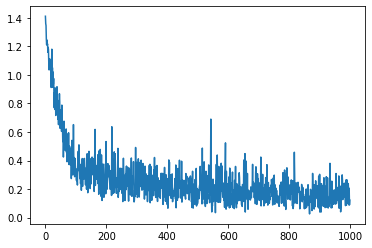

In [97]:
plt.plot(losses)